In [41]:
# imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


In [42]:
data = pd.read_csv('Data/historical_BTCUSDT_3min_data.csv')

In [43]:
data

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
0,1598918400000,11649.51,11668.50,11649.50,11667.12,165.713325,1598918579999,1.932464e+06,2146,83.409576,9.725705e+05,0
1,1598918580000,11667.12,11667.72,11634.06,11645.19,248.783097,1598918759999,2.897763e+06,3230,92.608664,1.078562e+06,0
2,1598918760000,11645.51,11649.88,11629.00,11639.12,217.735241,1598918939999,2.534315e+06,5186,93.190672,1.084609e+06,0
3,1598918940000,11639.12,11642.21,11630.21,11639.01,169.768550,1598919119999,1.975641e+06,3282,56.131767,6.532171e+05,0
4,1598919120000,11639.00,11640.01,11627.22,11634.16,130.973394,1598919299999,1.523519e+06,2300,45.500733,5.292799e+05,0
...,...,...,...,...,...,...,...,...,...,...,...,...
631196,1712620080000,71636.00,71683.82,71635.99,71676.45,22.694870,1712620259999,1.626456e+06,2027,10.817960,7.752474e+05,0
631197,1712620260000,71676.45,71676.46,71633.41,71636.83,15.908180,1712620439999,1.139815e+06,1209,5.646140,4.045180e+05,0
631198,1712620440000,71636.84,71636.84,71617.17,71621.38,24.054500,1712620619999,1.722863e+06,1326,7.466530,5.347731e+05,0
631199,1712620620000,71621.38,71662.94,71620.00,71620.00,42.037670,1712620799999,3.011572e+06,1624,17.243720,1.235209e+06,0


In [44]:
def find_threshold_crossing(df, start_index, percent):
    # Ensure the start_index is valid
    if start_index >= len(df):
        return None, None

    # Getting the open price at the start index
    open_price = df.loc[start_index, 'Open']

    # Calculating the thresholds
    threshold_up = open_price * (1 + percent/100)
    threshold_down = open_price * (1 - percent/100)

    # Variables to store the number of candles it took to cross each threshold
    up_cross = None
    down_cross = None

    # Calculate the maximum number of candles for 7 days
    max_candles = 7 * 24 * 20

    # Iterate through the dataframe starting from the start index
    for index, row in df.loc[start_index:].iterrows():
        if index - start_index > max_candles:
            # Stop if 7 days have passed without crossing either threshold
            break

        if up_cross is None and row['High'] >= threshold_up:
            up_cross = index - start_index

        if down_cross is None and row['Low'] <= threshold_down:
            down_cross = index - start_index

    return up_cross, down_cross

In [45]:
df = data
start_index = 0
result = find_threshold_crossing(df=df, start_index=0, percent=1)
print(result)

(118, 7)


## go to 02-1 threshold_data_gen.py and come back


In [46]:
threshold_data = pd.read_csv('Data/up_down_cross_3min_data.csv')

In [68]:
threshold_data = threshold_data[:len(data)]

In [69]:
print(len(threshold_data))

631201


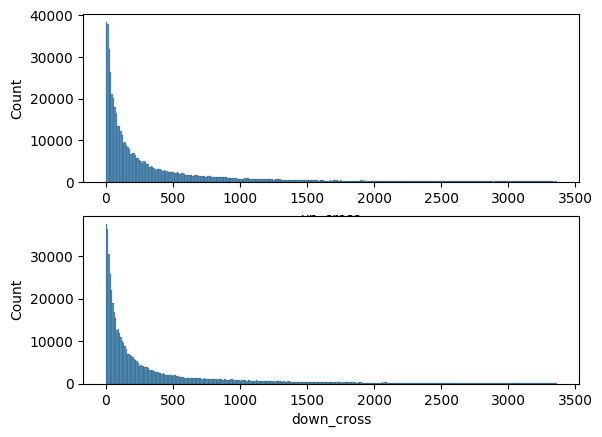

In [70]:
plt.subplot(2,1,1)
sns.histplot(threshold_data['up_cross'])

plt.subplot(2,1,2)
sns.histplot(threshold_data['down_cross'])

plt.show()

In [71]:
threshold_data.isna().sum()/len(threshold_data)*100

up_cross      10.499825
down_cross    13.592342
dtype: float64

In [72]:
temp = threshold_data.fillna(3360)

In [73]:
# Create the 'minutes' column
temp['minutes'] = temp[['up_cross', 'down_cross']].min(axis=1)*3

# Create the 'side' column
temp['side'] = temp.apply(lambda row: 1 if row['up_cross'] < row['down_cross'] else (-1 if row['up_cross'] > row['down_cross'] else 0), axis=1)

# Creating a new DataFrame with just the 'minutes' and 'side' columns
one_percent_data = temp[['minutes', 'side']]


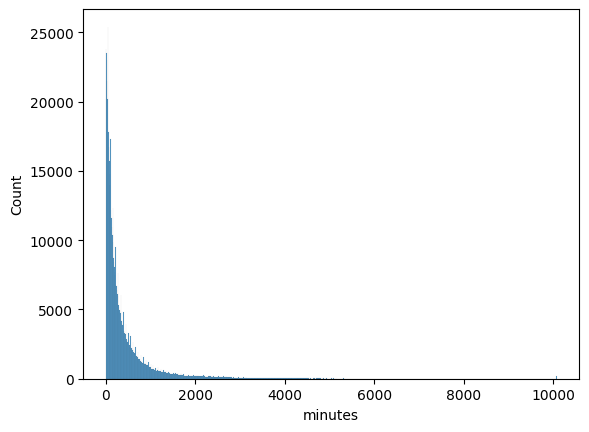

In [74]:
sns.histplot(one_percent_data['minutes'])
plt.show()

In [75]:
one_percent_data['minutes'].describe()

count    631201.000000
mean        423.929690
std         679.986223
min           0.000000
25%          69.000000
50%         189.000000
75%         477.000000
max       10080.000000
Name: minutes, dtype: float64

In [76]:
mean = one_percent_data['minutes'].mean()
median = one_percent_data['minutes'].median()
std_dev = one_percent_data['minutes'].std()
quartiles = one_percent_data['minutes'].quantile([0.25, 0.5, 0.75])

print(f"Mean: {mean}")
print(f"Median: {median}")
print(f"Standard Deviation: {std_dev}")
print(f"1st Quartile: {quartiles[0.25]}")
print(f"2nd Quartile (Median): {quartiles[0.5]}")
print(f"3rd Quartile: {quartiles[0.75]}")

Mean: 423.9296895917465
Median: 189.0
Standard Deviation: 679.9862230949224
1st Quartile: 69.0
2nd Quartile (Median): 189.0
3rd Quartile: 477.0


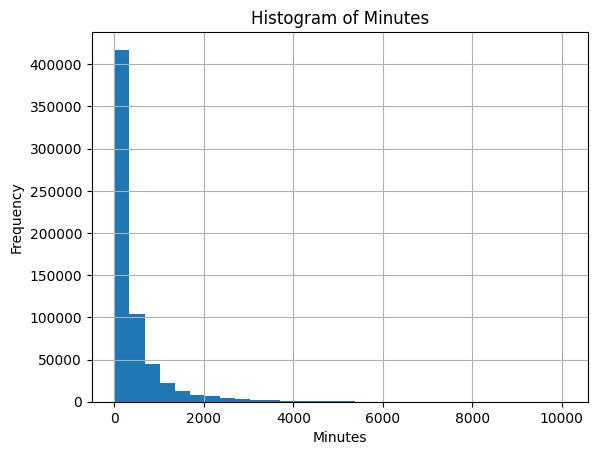

'\n# Q-Q plot\nstats.probplot(one_percent_data[\'minutes\'], dist="norm", plot=plt)\nplt.title(\'Q-Q Plot\')\nplt.show()\n'

In [77]:
# Histogram
one_percent_data['minutes'].hist(bins=30)
plt.title('Histogram of Minutes')
plt.xlabel('Minutes')
plt.ylabel('Frequency')
plt.show()

'''
# Q-Q plot
stats.probplot(one_percent_data['minutes'], dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()
'''

/tmp/ipykernel_24859/1886537575.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_percent_data['log_minutes'] = np.log(one_percent_data['minutes'] + 1)  # Adding 1 to avoid log(0)


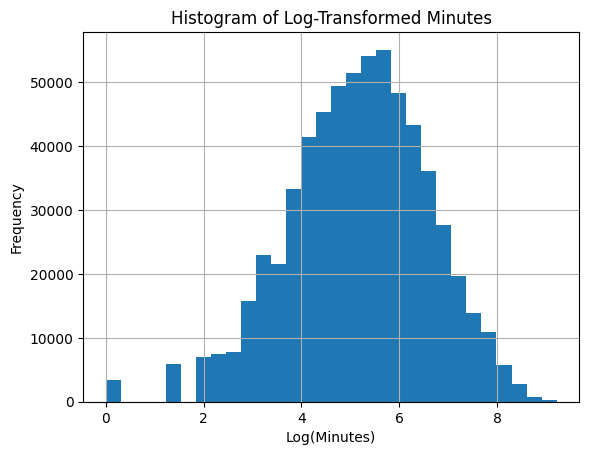

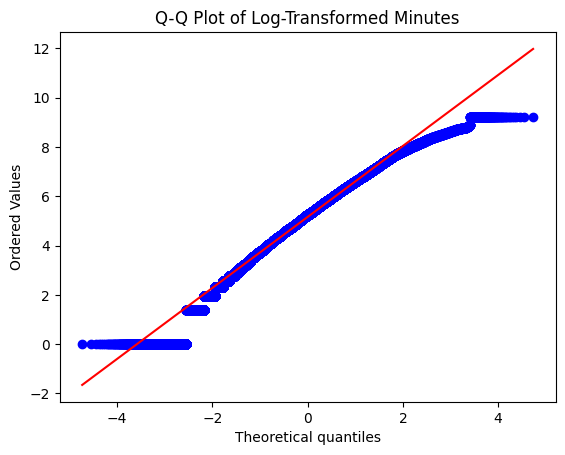

In [78]:
# Log Transformation
one_percent_data['log_minutes'] = np.log(one_percent_data['minutes'] + 1)  # Adding 1 to avoid log(0)

# Now, plot the histogram and Q-Q plot for the transformed data
one_percent_data['log_minutes'].hist(bins=30)
plt.title('Histogram of Log-Transformed Minutes')
plt.xlabel('Log(Minutes)')
plt.ylabel('Frequency')
plt.show()

stats.probplot(one_percent_data['log_minutes'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Log-Transformed Minutes')
plt.show()

In [79]:
# remove the outliers
total_length = len(one_percent_data)
side_zeros = len(one_percent_data[one_percent_data['side']==0])
print(f'side = 0 values : {side_zeros/total_length*100}%\n')
more_than_a_day = one_percent_data[one_percent_data['minutes']>24*60]
print(f'took more than a day values : {len(more_than_a_day)/total_length*100}%')
more_than_12hours = one_percent_data[one_percent_data['minutes']>12*60]
print(f'took more than 12 hours values : {len(more_than_12hours)/total_length*100}%')
more_than_8hours = one_percent_data[one_percent_data['minutes']>8*60]
print(f'took more than 8 hours values : {len(more_than_8hours)/total_length*100}%')
more_than_6hours = one_percent_data[one_percent_data['minutes']>6*60]
print(f'took more than 6 hours values : {len(more_than_6hours)/total_length*100}%')
more_than_4hours = one_percent_data[one_percent_data['minutes']>4*60]
print(f'took more than 4 hours values : {len(more_than_4hours)/total_length*100}%')
more_than_3hours = one_percent_data[one_percent_data['minutes']>3*60]
print(f'took more than 3 hours values : {len(more_than_3hours)/total_length*100}%')
more_than_2half_hours = one_percent_data[one_percent_data['minutes']>2.5*60]
print(f'took more than 2.5 hours values : {len(more_than_2half_hours)/total_length*100}%')
more_than_2hours = one_percent_data[one_percent_data['minutes']>2*60]
print(f'took more than 2 hours values : {len(more_than_2hours)/total_length*100}%')

print('')

less_than_15minutes = one_percent_data[one_percent_data['minutes']<15]
print(f'took less than 15 minutes values : {len(less_than_15minutes)/total_length*100}%')
less_than_30minutes = one_percent_data[one_percent_data['minutes']<30]
print(f'took less than 30 minutes values : {len(less_than_30minutes)/total_length*100}%')
less_than_45minutes = one_percent_data[one_percent_data['minutes']<45]
print(f'took less than 45 minutes values : {len(less_than_45minutes)/total_length*100}%')
less_than_1hours = one_percent_data[one_percent_data['minutes']<60]
print(f'took less than 1 hour values : {len(less_than_1hours)/total_length*100}%')
less_than_1half_hours = one_percent_data[one_percent_data['minutes']<90]
print(f'took less than 1.5 hour values : {len(less_than_1half_hours)/total_length*100}%')

side = 0 values : 0.16286412727483005%

took more than a day values : 6.330630021181842%
took more than 12 hours values : 16.07823815234767%
took more than 8 hours values : 24.80240050316777%
took more than 6 hours values : 31.858472974535847%
took more than 4 hours values : 42.962542835008186%
took more than 3 hours values : 50.92371526661079%
took more than 2.5 hours values : 55.828175177162265%
took more than 2 hours values : 61.675282516979536%

took less than 15 minutes values : 4.99856622533868%
took less than 30 minutes values : 11.135755488346819%
took less than 45 minutes values : 16.689137057767653%
took less than 1 hour values : 21.760104942799522%
took less than 1.5 hour values : 30.521814762650884%


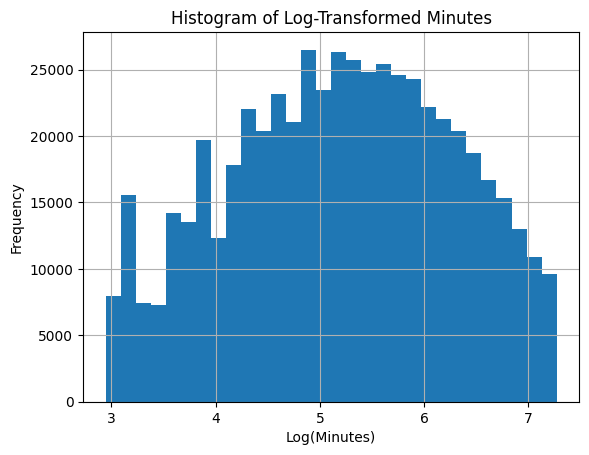

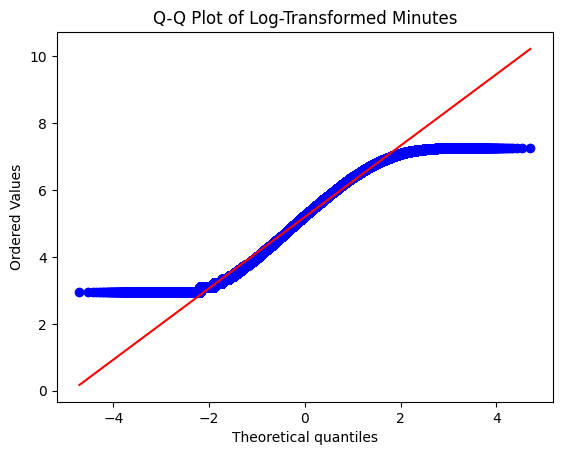

In [80]:
middle_values = one_percent_data[(one_percent_data['minutes']<24*60)&(one_percent_data['minutes']>15)]

# Now, plot the histogram and Q-Q plot for the transformed data
middle_values['log_minutes'].hist(bins=30)
plt.title('Histogram of Log-Transformed Minutes')
plt.xlabel('Log(Minutes)')
plt.ylabel('Frequency')
plt.show()

stats.probplot(middle_values['log_minutes'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Log-Transformed Minutes')
plt.show()

In [81]:
np.e**2

7.3890560989306495

In [82]:
np.e**7

1096.6331584284583

In [83]:
less_than_3hours = one_percent_data[one_percent_data['minutes']<3*60]

less_than_3hours

,minutes,side,log_minutes
0,21.0,-1,3.091042
1,18.0,-1,2.944439
2,15.0,-1,2.772589
3,12.0,-1,2.564949
4,9.0,-1,2.302585
...,...,...,...
630995,60.0,-1,4.110874
630996,54.0,-1,4.007333
630997,54.0,-1,4.007333
630998,51.0,-1,3.951244


In [84]:
print(f'up cross : {len(less_than_3hours[less_than_3hours['side']>0])/total_length}')
print(f'down cross : {len(less_than_3hours[less_than_3hours['side']<0])/total_length}')

up cross : 0.23888903851546497
down cross : 0.2469609522164889


In [85]:
temp2 = one_percent_data.copy()
temp2['plus_6'] = ((temp2['minutes']<6*60)&(temp2['side']>0)).astype(int)
temp2['minus_6'] = ((temp2['minutes']<6*60)&(temp2['side']<0)).astype(int)
temp2['zero_6'] = ((temp2['minutes']>=6*60)|(temp2['side']==0)).astype(int)
data2 = temp2

In [86]:
df_all = pd.concat([data,threshold_data,data2],axis=1)

df_all

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore,up_cross,down_cross,minutes,side,log_minutes,plus_6,minus_6,zero_6
0,1598918400000,11649.51,11668.50,11649.50,11667.12,165.713325,1598918579999,1.932464e+06,2146,83.409576,9.725705e+05,0,118.0,7.0,21.0,-1,3.091042,0,1,0
1,1598918580000,11667.12,11667.72,11634.06,11645.19,248.783097,1598918759999,2.897763e+06,3230,92.608664,1.078562e+06,0,117.0,6.0,18.0,-1,2.944439,0,1,0
2,1598918760000,11645.51,11649.88,11629.00,11639.12,217.735241,1598918939999,2.534315e+06,5186,93.190672,1.084609e+06,0,116.0,5.0,15.0,-1,2.772589,0,1,0
3,1598918940000,11639.12,11642.21,11630.21,11639.01,169.768550,1598919119999,1.975641e+06,3282,56.131767,6.532171e+05,0,115.0,4.0,12.0,-1,2.564949,0,1,0
4,1598919120000,11639.00,11640.01,11627.22,11634.16,130.973394,1598919299999,1.523519e+06,2300,45.500733,5.292799e+05,0,114.0,3.0,9.0,-1,2.302585,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631196,1712620080000,71636.00,71683.82,71635.99,71676.45,22.694870,1712620259999,1.626456e+06,2027,10.817960,7.752474e+05,0,NaN,NaN,10080.0,0,9.218408,0,0,1
631197,1712620260000,71676.45,71676.46,71633.41,71636.83,15.908180,1712620439999,1.139815e+06,1209,5.646140,4.045180e+05,0,NaN,NaN,10080.0,0,9.218408,0,0,1
631198,1712620440000,71636.84,71636.84,71617.17,71621.38,24.054500,1712620619999,1.722863e+06,1326,7.466530,5.347731e+05,0,NaN,NaN,10080.0,0,9.218408,0,0,1
631199,1712620620000,71621.38,71662.94,71620.00,71620.00,42.037670,1712620799999,3.011572e+06,1624,17.243720,1.235209e+06,0,NaN,NaN,10080.0,0,9.218408,0,0,1


In [87]:
# Create a boolean series where True indicates the rows with the sum equal to 1
rows_with_sum_one = (df_all['plus_6'] + df_all['minus_6'] + df_all['zero_6']) == 1

# Check if all values in the boolean series are True
all_rows_sum_to_one = rows_with_sum_one.all()

print(f"All rows have a sum of 1: {all_rows_sum_to_one}")


All rows have a sum of 1: True


In [88]:
df_all.to_csv('Data/df_all.csv', index=False)

In [89]:
temp3 = pd.read_csv('Data/df_all.csv')
temp3

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore,up_cross,down_cross,minutes,side,log_minutes,plus_6,minus_6,zero_6
0,1598918400000,11649.51,11668.50,11649.50,11667.12,165.713325,1598918579999,1.932464e+06,2146,83.409576,9.725705e+05,0,118.0,7.0,21.0,-1,3.091042,0,1,0
1,1598918580000,11667.12,11667.72,11634.06,11645.19,248.783097,1598918759999,2.897763e+06,3230,92.608664,1.078562e+06,0,117.0,6.0,18.0,-1,2.944439,0,1,0
2,1598918760000,11645.51,11649.88,11629.00,11639.12,217.735241,1598918939999,2.534315e+06,5186,93.190672,1.084609e+06,0,116.0,5.0,15.0,-1,2.772589,0,1,0
3,1598918940000,11639.12,11642.21,11630.21,11639.01,169.768550,1598919119999,1.975641e+06,3282,56.131767,6.532171e+05,0,115.0,4.0,12.0,-1,2.564949,0,1,0
4,1598919120000,11639.00,11640.01,11627.22,11634.16,130.973394,1598919299999,1.523519e+06,2300,45.500733,5.292799e+05,0,114.0,3.0,9.0,-1,2.302585,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631196,1712620080000,71636.00,71683.82,71635.99,71676.45,22.694870,1712620259999,1.626456e+06,2027,10.817960,7.752474e+05,0,NaN,NaN,10080.0,0,9.218408,0,0,1
631197,1712620260000,71676.45,71676.46,71633.41,71636.83,15.908180,1712620439999,1.139815e+06,1209,5.646140,4.045180e+05,0,NaN,NaN,10080.0,0,9.218408,0,0,1
631198,1712620440000,71636.84,71636.84,71617.17,71621.38,24.054500,1712620619999,1.722863e+06,1326,7.466530,5.347731e+05,0,NaN,NaN,10080.0,0,9.218408,0,0,1
631199,1712620620000,71621.38,71662.94,71620.00,71620.00,42.037670,1712620799999,3.011572e+06,1624,17.243720,1.235209e+06,0,NaN,NaN,10080.0,0,9.218408,0,0,1
